# 一、前期工作

本文将手把手教你用TensorFlow2实现`车牌识别`，整个项目的完整代码都在文章了哈，大家按顺序copy即可运行。

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1OlDvG4Pye7M9K043yw24XQ （提取码：e7fs）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1

## 1.设置GPU

如果使用的是CPU可以注释掉这部分的代码，不影响运行。

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

## 2.导入数据

In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL,random,pathlib

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

In [3]:
data_dir = "D:/jupyter notebook/DL-100-days/datasets/015_licence_plate"
data_dir = pathlib.Path(data_dir)

pictures_paths = list(data_dir.glob('*'))
pictures_paths = [str(path) for path in pictures_paths]
pictures_paths[:3]

['D:\\jupyter notebook\\DL-100-days\\datasets\\015_licence_plate\\000000000_川W9BR26.jpg',
 'D:\\jupyter notebook\\DL-100-days\\datasets\\015_licence_plate\\000000001_沪E264UD.jpg',
 'D:\\jupyter notebook\\DL-100-days\\datasets\\015_licence_plate\\000000002_浙E198UJ.jpg']

In [4]:
image_count = len(list(pictures_paths))

print("图片总数为：",image_count)

图片总数为： 13056


In [5]:
# 获取数据标签
all_label_names = [path.split("_")[-1].split(".")[0] for path in pictures_paths]
all_label_names[:3]

['川W9BR26', '沪E264UD', '浙E198UJ']

## 3.数据可视化

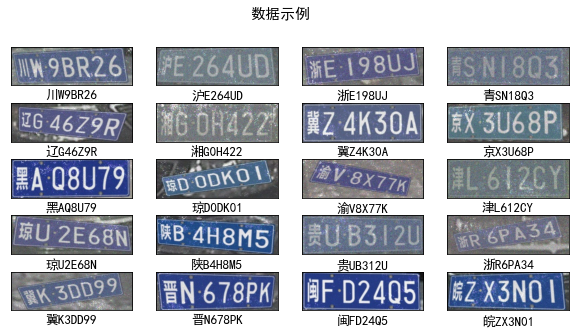

In [6]:
plt.figure(figsize=(10,5))
plt.suptitle("数据示例",fontsize=15)

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # 显示图片
    images = plt.imread(pictures_paths[i])
    plt.imshow(images)
    # 显示标签
    plt.xlabel(all_label_names[i],fontsize=13)

plt.show()

## 4.标签数字化

In [7]:
char_enum = ["京","沪","津","渝","冀","晋","蒙","辽","吉","黑","苏","浙","皖","闽","赣","鲁",\
              "豫","鄂","湘","粤","桂","琼","川","贵","云","藏","陕","甘","青","宁","新","军","使"]

number   = [str(i) for i in range(0, 10)]    # 0 到 9 的数字
alphabet = [chr(i) for i in range(65, 91)]   # A 到 Z 的字母

char_set       = char_enum + number + alphabet
char_set_len   = len(char_set)
label_name_len = len(all_label_names[0])

# 将字符串数字化
def text2vec(text):
    vector = np.zeros([label_name_len, char_set_len])
    for i, c in enumerate(text):
        idx = char_set.index(c)
        vector[i][idx] = 1.0
    return vector

all_labels = [text2vec(i) for i in all_label_names]

# 二、构建一个tf.data.Dataset

## 1.预处理函数

In [8]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [50, 200])
    return image/255.0

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

## 2.加载数据

构建 `tf.data.Dataset` 最简单的方法就是使用 `from_tensor_slices` 方法。

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

path_ds  = tf.data.Dataset.from_tensor_slices(pictures_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(all_labels)

image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<ZipDataset shapes: ((50, 200, 1), (7, 69)), types: (tf.float32, tf.float64)>

In [10]:
train_ds = image_label_ds.take(5000).shuffle(5000)  # 前1000个batch
val_ds   = image_label_ds.skip(5000).shuffle(1000)  # 跳过前1000，选取后面的

## 3.配置数据

先复习一下`prefetch()`函数。`prefetch()`功能详细介绍：CPU 正在准备数据时，加速器处于空闲状态。相反，当加速器正在训练模型时，CPU 处于空闲状态。因此，训练所用的时间是 CPU 预处理时间和加速器训练时间的总和。`prefetch()`将训练步骤的预处理和模型执行过程重叠到一起。当加速器正在执行第 N 个训练步时，CPU 正在准备第 N+1 步的数据。这样做不仅可以最大限度地缩短训练的单步用时（而不是总用时），而且可以缩短提取和转换数据所需的时间。如果不使用`prefetch()`，CPU 和 GPU/TPU 在大部分时间都处于空闲状态：

![](pictures/12-1.png)

使用`prefetch()`可显著减少空闲时间：

![image.png](pictures/12-2.png)

In [11]:
BATCH_SIZE = 16

train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
val_ds

<PrefetchDataset shapes: ((None, 50, 200, 1), (None, 7, 69)), types: (tf.float32, tf.float64)>

# 三、搭建网络模型

目前这里主要是带大家跑通代码、整理一下思路，大家可以自行优化网络结构、调整模型参数。后续我也会针对性的出一些调优的案例的。

In [12]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 200, 1)),#卷积层1，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   #池化层1，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  #卷积层2，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   #池化层2，2*2采样
    
    layers.Flatten(),                              #Flatten层，连接卷积层与全连接层
#     layers.Dense(1000, activation='relu'),         #全连接层，特征进一步提取
    layers.Dense(1000, activation='relu'),         #全连接层，特征进一步提取
    layers.Dropout(0.3),  
    layers.Dense(label_name_len * char_set_len),
    layers.Reshape([label_name_len, char_set_len]),
    layers.Softmax()                               #输出层，输出预期结果
])
# 打印网络结构
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 198, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 48, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33792)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              33793000  
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0

# 四、设置动态学习率

这里先罗列一下学习率大与学习率小的优缺点。

- 学习率大
    - 优点：
        1、加快学习速率。
        2、有助于跳出局部最优值。
    - 缺点：
        1、导致模型训练不收敛。
        2、单单使用大学习率容易导致模型不精确。

- 学习率小
    - 优点：
        1、有助于模型收敛、模型细化。
        2、提高模型精度。
    - 缺点：
        1、很难跳出局部最优值。
        2、收敛缓慢。

注意：这里设置的动态学习率为：指数衰减型（ExponentialDecay）。在每一个epoch开始前，学习率（learning_rate）都将会重置为初始学习率（initial_learning_rate），然后再重新开始衰减。计算公式如下：

>learning_rate = initial_learning_rate * decay_rate ^ (step / decay_steps)

In [13]:
# 设置初始学习率
initial_learning_rate = 1e-3

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, 
        decay_steps=50,      # 敲黑板！！！这里是指 steps，不是指epochs
        decay_rate=0.96,     # lr经过一次衰减就会变成 decay_rate*lr
        staircase=True)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 五、编译

In [14]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 六、训练

In [15]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
313/313 [==============================] - 9s 17ms/step - loss: 3.5249 - accuracy: 0.0537 - val_loss: 3.3293 - val_accuracy: 0.0610
Epoch 2/50
313/313 [==============================] - 5s 14ms/step - loss: 3.3078 - accuracy: 0.0769 - val_loss: 3.1374 - val_accuracy: 0.2068
Epoch 3/50
313/313 [==============================] - 5s 14ms/step - loss: 2.8676 - accuracy: 0.2455 - val_loss: 2.4188 - val_accuracy: 0.3579
Epoch 4/50
313/313 [==============================] - 5s 14ms/step - loss: 2.1170 - accuracy: 0.4031 - val_loss: 2.0383 - val_accuracy: 0.4391
Epoch 5/50
313/313 [==============================] - 5s 14ms/step - loss: 1.6881 - accuracy: 0.5104 - val_loss: 1.8287 - val_accuracy: 0.4879
Epoch 6/50
313/313 [==============================] - 5s 14ms/step - loss: 1.3931 - accuracy: 0.5900 - val_loss: 1.7230 - val_accuracy: 0.5100
Epoch 7/50
313/313 [==============================] - 5s 14ms/step - loss: 1.2091 - accuracy: 0.6429 - val_loss: 1.6496 - val_accuracy: 0.5278

# 七、模型评估

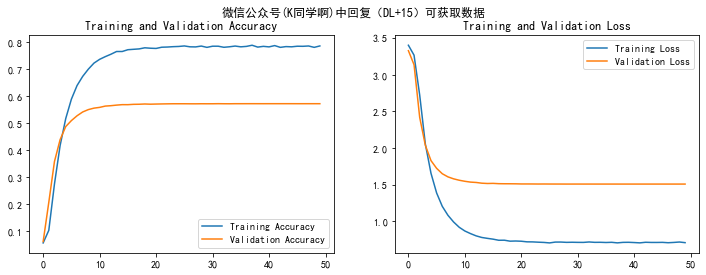

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.suptitle("微信公众号(K同学啊)中回复（DL+15）可获取数据",fontsize=12)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 八、保存和加载模型

In [17]:
# 保存模型
model.save('model/15_model.h5')

In [18]:
# 加载模型
new_model = tf.keras.models.load_model('model/15_model.h5')

# 九、预测

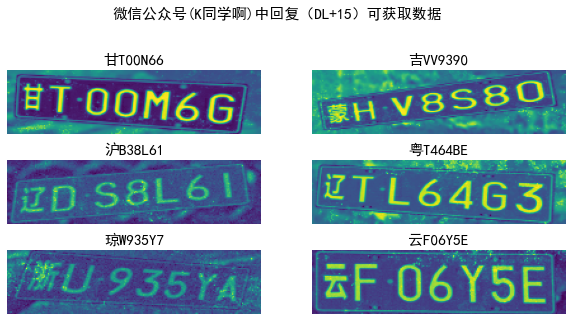

In [19]:
def vec2text(vec):
    """
    还原标签（向量->字符串）
    """
    text = []
    for i, c in enumerate(vec):
        text.append(char_set[c])
    return "".join(text)

plt.figure(figsize=(10, 8))            # 图形的宽为10高为8
plt.suptitle("微信公众号(K同学啊)中回复（DL+15）可获取数据",fontsize=15)

for images, labels in val_ds.take(1):
    for i in range(6):
        ax = plt.subplot(5, 2, i + 1)  
        # 显示图片
        plt.imshow(images[i])

        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 

        # 使用模型预测验证码
        predictions = model.predict(img_array)
        plt.title(vec2text(np.argmax(predictions, axis=2)[0]),fontsize=15)

        plt.axis("off")

**推荐阅读：**

✨ [**深度学习100例-卷积神经网络（CNN）实现mnist手写数字识别 | 第1天**](https://mtyjkh.blog.csdn.net/article/details/116920825) 

✨ [**这也太强了吧，我用它识别交通标志，准确率竟然高达97.9% | 第14天**](https://mtyjkh.blog.csdn.net/article/details/118389790)

✨ [**深度学习100例 - 卷积神经网络（Inception V3）识别手语 | 第13天**](https://mtyjkh.blog.csdn.net/article/details/118310170)

✨ [**手把手教你用 CNN 识别验证码 - 深度学习100例 | 第12天**](https://mtyjkh.blog.csdn.net/article/details/118152545)

✨ [**循环神经网络（LSTM）实现股票预测-深度学习100例 | 第10天**](https://mtyjkh.blog.csdn.net/article/details/117907074)

✨ [**深度学习100例-卷积神经网络（VGG-16）识别海贼王草帽一伙 | 第6天**](https://mtyjkh.blog.csdn.net/article/details/117331631)


**🚀 来自专栏：[《深度学习100例》](https://blog.csdn.net/qq_38251616/category_11068756.html)**

**关注、点赞、收藏，送我上热搜，谢谢大家啦！**